In [121]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [122]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet',
    'data/validation-00000-of-00001-cc3c5779fe22e8ca.parquet',
    # 'data/test-00000-of-00001-9c204eb3f4e11791.parquet',
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])

In [123]:
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


In [124]:
json.loads(df['ground_truth'].iloc[4])['valid_line']

[{'words': [{'quad': {'x2': 172,
     'y3': 836,
     'x3': 172,
     'y4': 836,
     'x1': 96,
     'y1': 800,
     'x4': 96,
     'y2': 800},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BASO'},
   {'quad': {'x2': 272,
     'y3': 834,
     'x3': 272,
     'y4': 834,
     'x1': 180,
     'y1': 798,
     'x4': 180,
     'y2': 798},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BIHUN'}],
  'category': 'menu.nm',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 444,
     'y3': 830,
     'x3': 444,
     'y4': 830,
     'x1': 424,
     'y1': 796,
     'x4': 424,
     'y2': 796},
    'is_key': 0,
    'row_id': 2119099,
    'text': '1'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 558,
     'y3': 830,
     'x3': 558,
     'y4': 830,
     'x1': 454,
     'y1': 794,
     'x4': 454,
     'y2': 794},
    'is_key': 0,
    'row_id': 2119099,
    'text': '43.636'}],
  'category': 'menu.unitprice',
  'group_id': 3,
  

In [125]:
determined_labels = {'total_text': 0, 'total_value': 1, 'tax_text': 2, 'tax_value': 3, 'other': 4}

In [126]:
# Fungsi transformasi
def transform_json(data):
    result = []
    for item in data:
        category = item.get("category", "").lower()
        for word in item.get("words", []):
            quad = word.get("quad", {})
            is_key = word.get("is_key", 0)
            text = word.get("text", "")
            
            # Penentuan label
            if category == "total.total_price":
                label = "total_text" if is_key == 1 else "total_value"
            elif category == "sub_total.tax_price":
                label = "tax_text" if is_key == 1 else "tax_value"
            else:
                label = "other"
            
            # Menambahkan hasil transformasi ke list hasil
            result.append({
                "quad": quad,
                "text": text,
                "label": label
            })
    return result

# Fungsi untuk proses seluruh kolom
def process_dataframe(row):
    # Parsing data JSON dari kolom
    valid_line = json.loads(row)['valid_line']

    # Ambil size gambar
    meta = json.loads(row).get('meta', {})
    image_size = meta.get('image_size', None)

    # Transformasi data menggunakan fungsi sebelumnya
    transformed_data = transform_json(valid_line)

    # Mengembalikan hasil transformasi dan image_size
    return image_size, transformed_data

# Menerapkan ke seluruh DataFrame
df['transformed'] = df['ground_truth'].apply(process_dataframe)

In [135]:
df['transformed']

0     ({'width': 864, 'height': 1296}, [{'quad': {'x...
1     ({'width': 864, 'height': 1296}, [{'quad': {'x...
2     ({'width': 720, 'height': 1280}, [{'quad': {'x...
3     ({'width': 1108, 'height': 1478}, [{'quad': {'...
4     ({'width': 864, 'height': 1296}, [{'quad': {'x...
                            ...                        
95    ({'width': 720, 'height': 1280}, [{'quad': {'x...
96    ({'width': 864, 'height': 1296}, [{'quad': {'x...
97    ({'width': 864, 'height': 1296}, [{'quad': {'x...
98    ({'width': 576, 'height': 864}, [{'quad': {'x2...
99    ({'width': 864, 'height': 1296}, [{'quad': {'x...
Name: transformed, Length: 900, dtype: object

In [128]:
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# import json

# # Fungsi untuk mengekstrak fitur dan label dari data transformasi
# def extract_features_and_labels(transformed_data):
#     features = []
#     labels = []
#     for row in transformed_data:
#         for item in row:
#             quad = item["quad"]
#             text = item["text"]
#             label = item["label"]
            
#             # Menyusun fitur dari quad dan panjang teks
#             feature = [
#                 quad["x1"], quad["y1"], quad["x2"], quad["y2"], 
#                 quad["x3"], quad["y3"], quad["x4"], quad["y4"],
#                 len(text)
#             ]
#             features.append(feature)
#             labels.append(label)
#     return np.array(features), np.array(labels)

# # Mengekstrak fitur dan label
# features, labels = extract_features_and_labels(df["transformed"])

# # Encode label menjadi angka
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

# # Membagi data menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# # Membangun model TensorFlow
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(features.shape[1],)),  # Input layer sesuai jumlah fitur
#     tf.keras.layers.Dense(128, activation='relu'),               # Hidden layer 1
#     tf.keras.layers.Dense(128, activation='relu'),               # Hidden layer 1
#     tf.keras.layers.Dense(64, activation='relu'),                # Hidden layer 2
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer dengan softmax
# ])

# # Kompilasi model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Melatih model
# history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# # Mengevaluasi model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.2f}")

# # Fungsi untuk prediksi kelas
# def predict_class(quad, text):
#     feature = [
#         quad["x1"], quad["y1"], quad["x2"], quad["y2"], 
#         quad["x3"], quad["y3"], quad["x4"], quad["y4"],
#         len(text)
#     ]
#     feature = np.array([feature])  # Ubah menjadi bentuk array 2D
#     predicted_label = model.predict(feature)
#     predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])
#     return predicted_class[0]

# # Contoh prediksi
# example_quad = {"x1": 1, "y1": 1, "x2": 2, "y2": 2, "x3": 3, "y3": 3, "x4": 4, "y4": 4}
# example_text = "TOTAL"
# predicted = predict_class(example_quad, example_text)
# print(f"Predicted Class: {predicted}")


## NLP TEXT SEQUENCE TF TOKENIZER

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter untuk teks
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 20

# Fungsi untuk menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

# Modifikasi fungsi untuk menyertakan posisi relatif
def extract_features_and_labels_with_position(transformed_data):
    features = []
    texts = []  # Menyimpan teks untuk NLP
    labels = []
    
    for row in transformed_data:
        reference_positions = {"total_text": None, "tax_text": None}

        image_size, boxs = row
        
        # Cari posisi total_text dan tax_text sebagai referensi
        for item in boxs:
            if item["label"] in reference_positions:
                reference_positions[item["label"]] = item

        for item in boxs:
            quad = item["quad"]
            text = item["text"]
            label = item["label"]

            # Fitur dasar geometris dan melakukan nomralisasi agar [0, 1] terhadap image size
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            
            # Tambahkan posisi relatif ke total_text dan tax_text
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada total_text
            
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada tax_text

            # if reference_positions["other"]:
            #     feature.extend(calculate_relative_position(item, reference_positions["other"]))
            # else:
            #     feature.extend([0, 0])  # Default jika tidak ada tax_text

            features.append(feature)
            texts.append(text)  # Menyimpan teks
            labels.append(label)
    return np.array(features), texts, np.array(labels)

# Mengekstrak fitur dan label
features, texts, labels = extract_features_and_labels_with_position(df["transformed"])

# Encode teks menjadi token menggunakan Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Membagi data menjadi training dan testing
X_train_features, X_test_features, X_train_text, X_test_text, y_train, y_test = train_test_split(
    features, text_padded, encoded_labels, test_size=0.2, random_state=42
)

# Membangun model TensorFlow
# Input untuk fitur geometris
geo_input = tf.keras.Input(shape=(features.shape[1],), name="geo_input")
geo_dense = tf.keras.layers.Dense(64, activation="relu")(geo_input)

# Input untuk teks
text_input = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
text_embed = tf.keras.layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64)(text_input)
text_lstm = tf.keras.layers.LSTM(64)(text_embed)

# Menggabungkan kedua input
combined = tf.keras.layers.concatenate([geo_dense, text_lstm])
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")(combined_dense)

# Membuat model
model = tf.keras.Model(inputs=[geo_input, text_input], outputs=output)

# Summary model
model.summary()

# Kompilasi model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Melatih model
history = model.fit(
    [X_train_features, X_train_text], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[callback]
)

# Mengevaluasi model
loss, accuracy = model.evaluate([X_test_features, X_test_text], y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 20, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │        832 │ geo_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     33,024 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128)       │          0 │ dense_28[0][0],   │
│ (Concatenate)       │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     16,512 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 5)         │        645 │ dense_29[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 691,013 (2.64 MB)

 Trainable params: 691,013 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['geo_input', 'text_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8639 - loss: 1.7128 - val_accuracy: 0.9467 - val_loss: 0.2422
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9500 - loss: 0.2814 - val_accuracy: 0.9638 - val_loss: 0.1675
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9641 - loss: 0.1843 - val_accuracy: 0.9684 - val_loss: 0.1465
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9636 - loss: 0.1988 - val_accuracy: 0.9707 - val_loss: 0.1451
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9724 - loss: 0.1311 - val_accuracy: 0.9672 - val_loss: 0.1292
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9725 - loss: 0.1494 - val_accuracy: 0.9693 - val_loss: 0.1454
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9827 - loss: 0.0860 - val_accuracy: 0.9745 - val_loss: 0.1303
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9832 - loss: 0.0787 - val_accurac

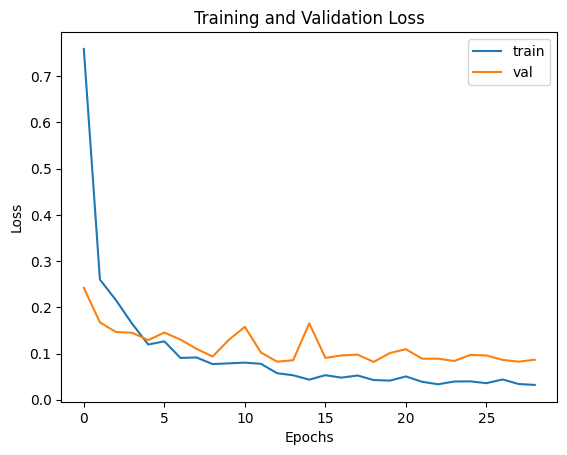

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

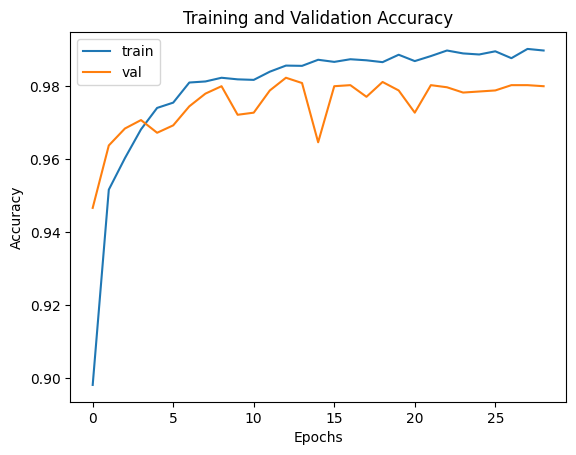

In [131]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [132]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi probabilitas
y_pred_prob = model.predict([X_test_features, X_test_text])

# Mengambil kelas prediksi (kelas dengan probabilitas tertinggi)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Menghitung metrik evaluasi untuk setiap kelas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Menyimpan hasil evaluasi ke dictionary
score_dict = {
    'accuracy_score': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
}

# Menampilkan hasil evaluasi
print("Evaluation Scores:")
print(f"Accuracy Score: {score_dict['accuracy_score']:.4f}")
print(f"Precision: {score_dict['precision']:.4f}")
print(f"Recall: {score_dict['recall']:.4f}")
print(f"F1 Score: {score_dict['f1_score']:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report:
               precision    recall  f1-score   support

       other       0.99      0.99      0.99      3681
    tax_text       0.96      0.94      0.95       138
   tax_value       0.86      0.95      0.90        95
  total_text       0.96      0.97      0.97       198
 total_value       0.94      0.83      0.88       199

    accuracy                           0.98      4311
   macro avg       0.94      0.94      0.94      4311
weighted avg       0.98      0.98      0.98      4311

Confusion Matrix:
 [[3647    4   12    8   10]
 [   7  130    1    0    0]
 [   4    1   90    0    0]
 [   4    0    0  193    1]
 [  32    0    2    0  165]]
Evaluation Scores:
Accuracy Score: 0.9801
Precision: 0.9801
Recall: 0.9801
F1 Score: 0.9799


In [139]:
def predict_class(quad, text, image_size, total_text_quad=None, tax_text_quad=None):
    
    # Memproses fitur geometris
    feature = [
        quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
        quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
        quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
        quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
    ]
    
    # Tambahkan posisi relatif terhadap total_text dan tax_text
    if total_text_quad:
        feature.extend(calculate_relative_position({"quad": quad}, {"quad": total_text_quad}))
    else:
        feature.extend([0, 0])  # Default jika tidak ada total_text
    
    if tax_text_quad:
        feature.extend(calculate_relative_position({"quad": quad}, {"quad": tax_text_quad}))
    else:
        feature.extend([0, 0])  # Default jika tidak ada tax_text
    
    # Ubah menjadi bentuk array 2D
    feature = np.array([feature])

    # Memproses teks
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Prediksi kelas
    predicted_probs = model.predict([feature, text_padded])
    predicted_label = np.argmax(predicted_probs, axis=1)
    predicted_class = label_encoder.inverse_transform(predicted_label)
    return predicted_class[0]


# Contoh input data
example_quad = {
      "x2": 277,
      "y3": 1034,
      "x3": 277,
      "y4": 1034,
      "x1": 187,
      "y1": 998,
      "x4": 187,
      "y2": 998
    }
total_text_quad =  {
      "x2": 277,
      "y3": 1034,
      "x3": 277,
      "y4": 1034,
      "x1": 187,
      "y1": 998,
      "x4": 187,
      "y2": 998
    }
tax_text_quad = {
      "x2": 284,
      "y3": 982,
      "x3": 284,
      "y4": 982,
      "x1": 258,
      "y1": 946,
      "x4": 258,
      "y2": 946
    }
image_size = {'width': 864, 'height': 1296}
example_text = "0000"

# Memanggil fungsi prediksi
predicted = predict_class(example_quad, example_text, image_size,  total_text_quad, tax_text_quad)
print(f"Predicted Class: {predicted}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Class: other


In [134]:
# Menampilkan daftar kata (word index) yang dihasilkan oleh Tokenizer
print("Word Index (Daftar Kata):")
print(tokenizer.word_index)

# Menampilkan hasil tokenisasi untuk beberapa teks
print("\nHasil Tokenisasi untuk setiap teks:")
for i, text in enumerate(texts[:5]):  # Ambil 5 teks pertama sebagai contoh
    print(f"Teks asli: {text}")
    print(f"Tokenisasi: {text_sequences[i]}")

Word Index (Daftar Kata):
{'000': 1, '1': 2, 'total': 3, '0': 4, 'cash': 5, '500': 6, '2': 7, '00': 8, 'change': 9, '10': 10, 'subtotal': 11, '20': 12, '3': 13, '50': 14, '100': 15, '5': 16, '22': 17, 'rp': 18, '25': 19, 'sub': 20, '12': 21, 'tax': 22, '4': 23, '30': 24, '6': 25, 'tea': 26, '8': 27, '9': 28, 'pb1': 29, '636': 30, 'item': 31, '17': 32, '1x': 33, '28': 34, '13': 35, 'grand': 36, 'x1': 37, 'cheese': 38, '15': 39, '7': 40, '18': 41, '16': 42, '40': 43, 'kembali': 44, '14': 45, '200': 46, '909': 47, 'nasi': 48, 'items': 49, 'choco': 50, '800': 51, '600': 52, 'discount': 53, 'ice': 54, '60': 55, 'due': 56, '19': 57, '45': 58, 'service': 59, 'tunai': 60, 'x': 61, '24': 62, '29': 63, 'p': 64, '36': 65, '43': 66, '23': 67, '727': 68, '26': 69, '11': 70, 'ayam': 71, '27': 72, 'disc': 73, 's': 74, 'bread': 75, '42': 76, 'medium': 77, 'chicken': 78, '182': 79, '21': 80, '091': 81, '900': 82, 'teh': 83, '70': 84, 'iced': 85, 'bca': 86, '273': 87, 'amount': 88, 'charge': 89, '35': 9

## NLP Character-lavel Embedding

In [140]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter
MAX_CHAR_VOCAB = 100  # Batas jumlah karakter unik
MAX_CHAR_SEQUENCE_LENGTH = 50  # Panjang maksimum teks dalam karakter

# Fungsi untuk menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

# Modifikasi fungsi untuk menyertakan posisi relatif
def extract_features_and_labels_with_position(transformed_data):
    features = []
    texts = []  # Menyimpan teks untuk NLP
    labels = []
    
    for row in transformed_data:
        reference_positions = {"total_text": None, "tax_text": None}

        image_size, boxs = row
        
        # Cari posisi total_text dan tax_text sebagai referensi
        for item in boxs:
            if item["label"] in reference_positions:
                reference_positions[item["label"]] = item

        for item in boxs:
            quad = item["quad"]
            text = item["text"]
            label = item["label"]

            # Fitur dasar geometris
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            
            # Tambahkan posisi relatif ke total_text dan tax_text
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada total_text
            
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada tax_text

            features.append(feature)
            texts.append(text)  # Menyimpan teks
            labels.append(label)
    return np.array(features), texts, np.array(labels)

# Ekstrak fitur dan label
features, texts, labels = extract_features_and_labels_with_position(df["transformed"])

# Encode teks ke level karakter
def char_tokenizer(texts):
    vocab = set("".join(texts))  # Membuat karakter unik
    char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}  # Mapping karakter ke indeks
    sequences = [[char_to_idx[char] for char in text] for text in texts]  # Tokenisasi
    return sequences, char_to_idx

char_sequences, char_to_idx = char_tokenizer(texts)
char_padded = pad_sequences(char_sequences, maxlen=MAX_CHAR_SEQUENCE_LENGTH)

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Membagi data
X_train_features, X_test_features, X_train_chars, X_test_chars, y_train, y_test = train_test_split(
    features, char_padded, encoded_labels, test_size=0.2, random_state=42
)

# Model TensorFlow
# Input untuk fitur geometris
geo_input = tf.keras.Input(shape=(features.shape[1],), name="geo_input")
geo_dense = tf.keras.layers.Dense(64, activation="relu")(geo_input)

# Input untuk karakter
char_input = tf.keras.Input(shape=(MAX_CHAR_SEQUENCE_LENGTH,), name="char_input")
char_embed = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input)
char_lstm = tf.keras.layers.LSTM(64)(char_embed)

# Gabungkan kedua input
combined = tf.keras.layers.concatenate([geo_dense, char_lstm])
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")(combined_dense)

# Buat model
model = tf.keras.Model(inputs=[geo_input, char_input], outputs=output)

# Summary model
model.summary()

# Kompilasi model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Latih model
history = model.fit(
    [X_train_features, X_train_chars], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[callback]
)

# Evaluasi model
loss, accuracy = model.evaluate([X_test_features, X_test_chars], y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 50, 64)    │      5,568 │ char_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │        832 │ geo_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     33,024 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128)       │          0 │ dense_31[0][0],   │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     16,512 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 5)         │        645 │ dense_32[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,581 (221.02 KB)

 Trainable params: 56,581 (221.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['geo_input', 'char_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.8509 - loss: 2.1105 - val_accuracy: 0.9432 - val_loss: 0.3183
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9363 - loss: 0.3466 - val_accuracy: 0.9632 - val_loss: 0.1874
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9504 - loss: 0.2588 - val_accuracy: 0.9559 - val_loss: 0.2314
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9579 - loss: 0.2634 - val_accuracy: 0.9640 - val_loss: 0.1967
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9704 - loss: 0.1427 - val_accuracy: 0.9620 - val_loss: 0.1784
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9728 - loss: 0.1125 - val_accuracy: 0.9649 - val_loss: 0.1603
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9770 - loss: 0.0921 - val_accuracy: 0.9693 - val_loss: 0.1297
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9757 - loss: 0.1068 - val_acc

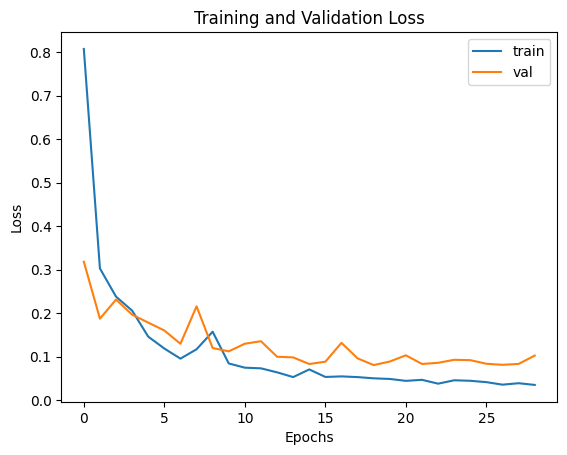

In [141]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

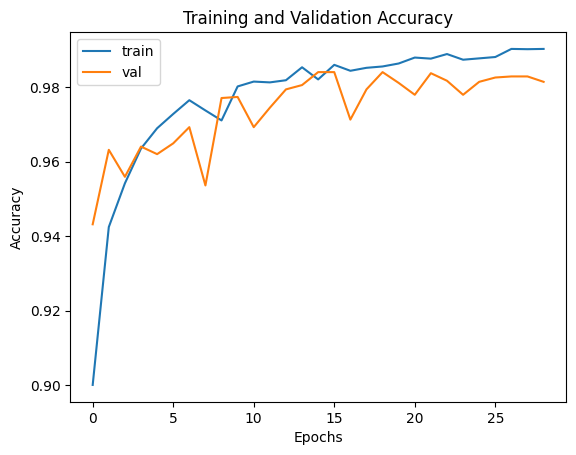

In [142]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [147]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi probabilitas
y_pred_prob = model.predict([X_test_features, X_test_chars])

# Mengambil kelas prediksi (kelas dengan probabilitas tertinggi)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Menghitung metrik evaluasi untuk setiap kelas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Menyimpan hasil evaluasi ke dictionary
score_dict = {
    'accuracy_score': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
}

# Menampilkan hasil evaluasi
print("Evaluation Scores:")
print(f"Accuracy Score: {score_dict['accuracy_score']:.4f}")
print(f"Precision: {score_dict['precision']:.4f}")
print(f"Recall: {score_dict['recall']:.4f}")
print(f"F1 Score: {score_dict['f1_score']:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Classification Report:
               precision    recall  f1-score   support

       other       0.99      0.99      0.99      3681
    tax_text       0.96      0.96      0.96       138
   tax_value       0.98      0.93      0.95        95
  total_text       0.98      0.95      0.96       198
 total_value       0.93      0.93      0.93       199

    accuracy                           0.99      4311
   macro avg       0.97      0.95      0.96      4311
weighted avg       0.99      0.99      0.99      4311

Confusion Matrix:
 [[3657    5    2    4   13]
 [   6  132    0    0    0]
 [   7    0   88    0    0]
 [  10    0    0  188    0]
 [  13    0    0    0  186]]
Evaluation Scores:
Accuracy Score: 0.9861
Precision: 0.9860
Recall: 0.9861
F1 Score: 0.9860
